In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
img_path = "/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/000000410343.jpg"

In [3]:
# Show image - by downloading the image
img = cv2.imread(img_path,1)
cv2.imwrite('hh.png',img)

True

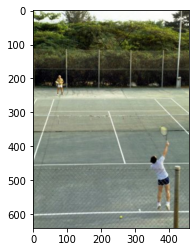

In [4]:
# Show images
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [42]:
# gaussian heatmap
 
def gaussian_heatmap(image_size, center_point, sigma):
    mu = 0.0
    sigma = sigma
    ro = 0

    center_x = center_point[0]
    center_y = center_point[1]

    grid_y, grid_x = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))

    x = grid_x - center_x
    y = grid_y - center_y

    return np.exp(-1 * (x ** 2 - 2 * ro * x * y + y**2) / (2 * (1 - ro**2)))

In [24]:
keypoint_name = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"],

In [25]:
import json
file = open('/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json')
data = json.load(file)

In [26]:
target_data = data['annotations'][4]  #4 -good # 11- two people 
key_point_data = target_data['keypoints']
bounding_box = target_data['bbox']
img_id = target_data['image_id']

/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/000000209468.jpg


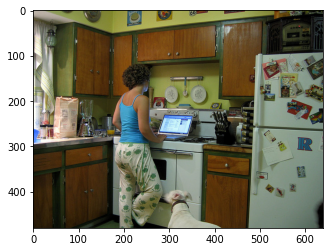

In [27]:
img_path = "/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/"
img_path = img_path+ "000000" + str(img_id) + ".jpg"
print(img_path)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [28]:

keypoint = []
keypoint_confidence = []
for i, k in enumerate(key_point_data):
    if i%3 != 0:
        continue
    if k != 0:
        coordinate = (key_point_data[i], key_point_data[i+1])
        confidence = key_point_data[i+2]
        keypoint.append(coordinate)
        keypoint_confidence.append(confidence)

print(keypoint)
print(keypoint_confidence)


[(252, 156), (248, 153), (198, 193), (243, 196), (182, 245), (244, 263), (276, 285), (197, 298), (228, 297), (208, 398), (266, 399), (205, 475), (215, 453)]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


[178.38, 120.54, 114.59, 354.6]


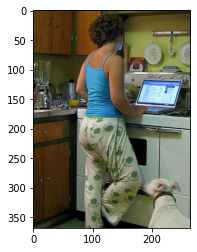

In [29]:
# crop the image to size (256*192 = 4:3)
# cropped_image = image[Y:Y+H, X:X+W]
print(bounding_box) #[x,y,width,height]
X,Y,width,height = bounding_box
X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1 #114, 354

width_trans, height_trans = X, Y
# 115, 354 -> 265, 354
if height/width < 4/3:
    original_height = height
    height = int(3*width/4)
    height_change = height - original_height
    ## 5% padding for robustness
    original_width = width
    width = int(width * 1.05)
    width_change = width - original_width

else:
    original_width = width
    width = int(3*height/4)
    width_change = width - original_width
    ## 5% padding for robustness
    original_height = height
    height = int(height * 1.05)
    height_change = height - original_height

cropped_image = image[Y-int(height_change/2):Y+height-int(height_change/2), X-int(width_change/2):X-int(width_change/2)+width]
width_trans = X - int(width_change/2)
height_trans = Y - int(height_change/2)

plt.imshow(cropped_image)
plt.show()

372 266


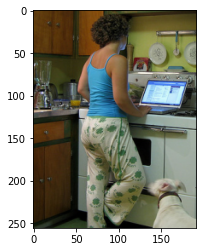

In [30]:
# resizing
print(height, width)

target_height = 256
target_width = 192
dim = (target_width, target_height)

resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)

plt.imshow(resized_image)
plt.show()

In [31]:
## adjust the keypoint coordinate
keypoint_translated = []
for k in keypoint:
    x,y = k
    x = (x-width_trans)*target_width/width;   y = (y-height_trans)*target_height/height
    if x <0 or y<0:
        keypoint_translated.append((0,0))
        continue
    k = (y,x)
    keypoint_translated.append(k)

keypoint_translated

[(30.27956989247312, 107.54887218045113),
 (28.21505376344086, 104.66165413533835),
 (55.74193548387097, 68.57142857142857),
 (57.806451612903224, 101.05263157894737),
 (91.52688172043011, 57.02255639097744),
 (103.91397849462365, 101.77443609022556),
 (119.05376344086021, 124.87218045112782),
 (128.0, 67.84962406015038),
 (127.31182795698925, 90.22556390977444),
 (196.81720430107526, 75.78947368421052),
 (197.50537634408602, 117.65413533834587),
 (249.80645161290323, 73.62406015037594),
 (234.66666666666666, 80.84210526315789)]

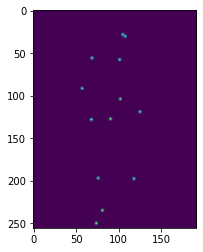

In [43]:
heatmap_list = []

for i, kp in enumerate(keypoint_translated):
    heatmap_i = gaussian_heatmap((192, 256), kp, keypoint_confidence[i])
    heatmap_list.append(heatmap_i)

h = np.stack(heatmap_list)
plt.imshow(h.max(axis=0)) 